# Build 60L1-60L2-3HR Multi-Fidelity Emulator for Matter Power Spectrum

A notebook to reproduce the results of 60L1-60L2-3HR emulator in MF-Box paper (Ho-Bird-Fernandez-Shelton 2021).

Terminology:

- L1: Low-fidelity dark matter only simulations, 128^3 particles, 256 Mpc/h
- L2: Low-fidelity dark matter only simulations, 128^3 particles, 100 Mpc/h
- HR: High-fidelity dark matter only simulations, 512^3 particles, 256 Mpc/h
- AR1: Linear multi-fidelity emulator from [Kennedy M., O’Hagan A., 2000, ](https://academic.oup.com/biomet/article-pdf/87/1/1/590577/870001.pdf)
- NARGP: Non-linear multi-fidelity emulator from Perdikaris P., Raissi M., Damianou A., Lawrence N. D., Karniadakis G. E., 2017, Proc. R. Soc. A., 473
- GMGP: Yi Ji, Simon Mak, Derek Soeder, J-F Paquet, Steffen A. Bass https://arxiv.org/abs/2108.00306
- MF-Box: MF-Box: Multi-fidelity and multi-scale emulation for the matter power spectrum https://arxiv.org/abs/2306.03144

Note: this notebook is doing the same thing as the benchmark function in examples/make_validations.py and examples/make_validations_dgmgp.py

Note: Simulations are outputed by [MP-Gadget](https://github.com/MP-Gadget/MP-Gadget), with boxsize = 256 Mpc/h. The code to re-run the dark matter only simulations from MP-Gadget in Latin hypercube is here https://github.com/jibanCat/SimulationRunnerDM


In [1]:
cd ..

/Users/jibanmac/Documents/GitHub/matter_emu_dgmgp


In [2]:
from typing import List

import os

import numpy as np
from matplotlib import pyplot as plt
import matplotlib

from matter_multi_fidelity_emu.gpemulator_singlebin import (
    SingleBinGP,
    SingleBinLinearGP,
    SingleBinNonLinearGP,
    SingleBindGMGP,
)
from matter_multi_fidelity_emu.data_loader import PowerSpecs, convert_h5_to_txt
from matter_multi_fidelity_emu.data_loader_dgmgp import interpolate

# set a random number seed to reproducibility
np.random.seed(0)


## Data processing


We have a separate repository for the power spectrum data


In [3]:
%%bash
folder="MFBoxData"
url="https://github.com/jibanCat/MFBoxData.git"
if ! git clone "${url}" "${folder}" 2>/dev/null && [ -d "${folder}" ] ; then
    echo "Clone failed because the folder ${folder} exists"
fi

Clone failed because the folder MFBoxData exists


In [4]:
# The list of folders contain power spectra from simulations
os.listdir(os.path.join("MFBoxData", "data"))


['dmo_10_res512box256',
 'dmo_60_res128box512',
 'dmo_60_res128box100',
 'dmo_60_res128box224',
 'dmo_60_res128box256',
 'dmo_300_res128box256',
 'dmo_10_res512box512',
 'dmo_60_res128box128',
 'dmo_60_res128box384',
 'dmo_60_res128box160',
 'dmo_60_res128box192',
 'dmo_24_res512box256']

The meaning of the folder names : `"dmo_{number of simulations}_res{particle load}box{boxsize in Mpc/h}"`


I have a simple function to convert the `.h5` file to easy-understanding txt files.

```python
def convert_h5_to_txt(
    lf_filename: str = "data/dmo_60_res128box256/cc_emulator_powerspecs.hdf5",
    hf_filename: str = "data/dmo_24_res512box256/cc_emulator_powerspecs.hdf5",
    test_filename: str = "data/dmo_10_res512box256/cc_emulator_powerspecs.hdf5",
    lf_json: str = "data/dmo_60_res128box256/emulator_params.json",
    hf_json: str = "data/dmo_24_res512box256/emulator_params.json",
    test_json: str = "data/dmo_10_res512box256/emulator_params.json",
    hf_selected_ind: Optional[List[int]] = [
        0,
        1,
        2,
    ],  ## these should be the index in the "LF" LHD
    num_lf: int = 60, # number of Low-fidelity design points
):
    """
    Convert the h5 files Martin gave me to txt files to be read by the dataloader.

    Keys:
    ----
    bounds : the bounds of the parameter prior
    powerspecs : Matter power spectrum (rebinned)
    kfmpc : k bins in Mpc/h unit
    params : un-normalized input parameters
    zout : redshifts
    scale_factors : 1 / (zout + 1)

    Parameters:
    ----
    hf_selected_ind : the selected subset for hf training set within the lf LHD.
    num_lf : number of LF design points, assuming to be params[:num_lf].

    Note: save each redshift as separate folders
    """

```


In [5]:
convert_h5_to_txt(
    lf_filename="MFBoxData/data/dmo_60_res128box256/cc_emulator_powerspecs.hdf5",
    hf_filename="MFBoxData/data/dmo_24_res512box256/cc_emulator_powerspecs.hdf5",
    test_filename="MFBoxData/data/dmo_10_res512box256/cc_emulator_powerspecs.hdf5",
    lf_json="MFBoxData/data/dmo_60_res128box256/emulator_params.json",
    hf_json="MFBoxData/data/dmo_24_res512box256/emulator_params.json",
    test_json="MFBoxData/data/dmo_10_res512box256/emulator_params.json",
    hf_selected_ind=[
        0,
        1,
        2,
    ],  ## these should be the index in the "LF" LHD
    num_lf=60,  # number of Low-fidelity design points
)

Low-fidelity file:
----
Resolution: 128
Box (Mpc/h): 256
Shape of redshfits (6,)
Shape of params (60, 5)
Shape of kfmpc (89,)
Shape of powerspecs (60, 6, 89)


=> Shape of powerspecs (60, 6, 89)
High-fidelity file:
----
Resolution: 512
Box (Mpc/h): 256
Shape of redshfits (6,)
Shape of params (24, 5)
Shape of kfmpc (130,)
Shape of powerspecs (24, 6, 130)
Selected indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 21 31 39 40 41 56 57 58 59]


Check: selected inds are, [0 1 2]
-> Shape of powerspecs (3, 6, 130)
-> Selected indices: [0 1 2]
Test file:
----
Resolution: 512
Box (Mpc/h): 256
Shape of redshfits (6,)
Shape of params (10, 5)
Shape of kfmpc (130,)
Shape of powerspecs (10, 6, 130)


Preparing training files in 0
96 89 89
[Info] rebin powerspecs from 89 k bins to 96 k bins.
New k bins:
----
Shape of kfmpc (96,)
Shape of LF powerspecs (60, 96)
Shape of HF powerspecs (3, 96)
Shape of Test powerspecs (10, 96)


Preparing training files in 0.2
96 89 89
[Info] rebin powerspecs from

In [6]:
convert_h5_to_txt(
    lf_filename="MFBoxData/data/dmo_60_res128box100/cc_emulator_powerspecs.hdf5",
    hf_filename="MFBoxData/data/dmo_24_res512box256/cc_emulator_powerspecs.hdf5",
    test_filename="MFBoxData/data/dmo_10_res512box256/cc_emulator_powerspecs.hdf5",
    lf_json="MFBoxData/data/dmo_60_res128box100/emulator_params.json",
    hf_json="MFBoxData/data/dmo_24_res512box256/emulator_params.json",
    test_json="MFBoxData/data/dmo_10_res512box256/emulator_params.json",
    hf_selected_ind=[
        0,
        1,
        2,
    ],  ## these should be the index in the "LF" LHD
    num_lf=60,  # number of Low-fidelity design points
)

Low-fidelity file:
----
Resolution: 128
Box (Mpc/h): 100
Shape of redshfits (6,)
Shape of params (60, 5)
Shape of kfmpc (89,)
Shape of powerspecs (60, 6, 89)


=> Shape of powerspecs (60, 6, 89)
High-fidelity file:
----
Resolution: 512
Box (Mpc/h): 256
Shape of redshfits (6,)
Shape of params (24, 5)
Shape of kfmpc (130,)
Shape of powerspecs (24, 6, 130)
Selected indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 21 31 39 40 41 56 57 58 59]


Check: selected inds are, [0 1 2]
-> Shape of powerspecs (3, 6, 130)
-> Selected indices: [0 1 2]
Test file:
----
Resolution: 512
Box (Mpc/h): 256
Shape of redshfits (6,)
Shape of params (10, 5)
Shape of kfmpc (130,)
Shape of powerspecs (10, 6, 130)


Preparing training files in 0
117 89 89
[Info] rebin powerspecs from 89 k bins to 117 k bins.
New k bins:
----
Shape of kfmpc (117,)
Shape of LF powerspecs (60, 117)
Shape of HF powerspecs (3, 117)
Shape of Test powerspecs (10, 117)


Preparing training files in 0.2
117 89 89
[Info] rebin powerspe

## Data: Here I choose z=1, but you can try other redshifts

... change the redshift by changing the `folder_1` and `folder_2` args.


In [7]:
# This is only redshift zero
def generate_data(
    folder_1: str = "data/processed/Matterpower_60_res128box256_3_res512box256_z1_ind-0-1-2/",
    folder_2: str = "data/processed/Matterpower_60_res128box100_3_res512box256_z1_ind-0-1-2/",
    n_fidelities: int = 2,
):
    data_1 = PowerSpecs(
        n_fidelities=n_fidelities,
    )
    data_1.read_from_txt(folder=folder_1)

    data_2 = PowerSpecs(
        n_fidelities=n_fidelities,
    )
    data_2.read_from_txt(folder=folder_2)

    return data_1, data_2

## Building your emulator


In [8]:
# functions for predicting on the test data
# test data are sampled from a Latin hypercube with 10 samples
def validate_mf(data: PowerSpecs, model: SingleBinNonLinearGP, fidelity: int = 1):
    """
    Validate the trained MFEmulators
    """
    all_modes = []
    all_vars = []
    all_pred_exacts = []
    for n_validations, (x_test, y_test) in enumerate(
        zip(data.X_test_norm[0], data.Y_test[0])
    ):
        x_test_index = np.concatenate(
            (x_test[None, :], np.ones((1, 1)) * fidelity), axis=1
        )
        mean, var = model.predict(x_test_index)  # mean, var of log10(P(k))

        # use mode (maximumlikelihood) as the prediction, restore the spectrum from log10(P(k)) which distributes normally
        mode_P = 10 ** mean[0] * np.exp(-var[0] * (np.log(10)) ** 2)
        var_P = (
            10 ** (2 * mean[0])
            * np.exp(var[0] * (np.log(10)) ** 2)
            * (np.exp(var[0] * (np.log(10)) ** 2) - 1)
        )

        all_modes.append(mode_P)
        all_vars.append(var_P)

        # predicted/exact
        all_pred_exacts.append(mode_P / 10**y_test)

    return all_modes, all_vars, all_pred_exacts


def validate_dgmgp(data: PowerSpecs, model: SingleBindGMGP, fidelity: int = 1):
    """
    Validate the trained MFEmulators
    """
    x_test, y_test = data.X_test_norm[0], data.Y_test[0]

    mean, var = model.predict(x_test)

    # use mode (maximumlikelihood) as the prediction, restore the spectrum from log10(P(k)) which distributes normally
    mode_P = 10**mean * np.exp(-var * (np.log(10)) ** 2)
    var_P = (
        10 ** (2 * mean)
        * np.exp(var * (np.log(10)) ** 2)
        * (np.exp(var * (np.log(10)) ** 2) - 1)
    )

    # If you'd like to use mean instead of mode, the variance is here:
    # ---
    # # dx = x dlog(x) = log(10) x dlog10(x)
    # # dlog10(x) = d(log(x) / log(10))
    # vars = (10**mean * np.log(10) * np.sqrt(var)) ** 2

    # predicted/exact
    pred_exacts = mode_P / 10**y_test

    return mode_P, var_P, pred_exacts


def validate_sf(data: PowerSpecs, model: SingleBinGP):
    """
    Validate the trained single-fidelity emulator
    """
    all_modes = []
    all_vars = []
    all_pred_exacts = []
    for n_validations, (x_test, y_test) in enumerate(
        zip(data.X_test_norm[0], data.Y_test[0])
    ):
        mean, var = model.predict(x_test[None, :])

        # use mode (maximumlikelihood) as the prediction, restore the spectrum from log10(P(k)) which distributes normally
        mode_P = 10 ** mean[0] * np.exp(-var[0] * (np.log(10)) ** 2)
        var_P = (
            10 ** (2 * mean[0])
            * np.exp(var[0] * (np.log(10)) ** 2)
            * (np.exp(var[0] * (np.log(10)) ** 2) - 1)
        )

        all_modes.append(mode_P)
        all_vars.append(var_P)

        # predicted/exact
        all_pred_exacts.append(mode_P / 10**y_test)

    return all_modes, all_vars, all_pred_exacts

In [9]:
def plot_parameters(
    X_train: List[np.ndarray],
    X_test: List[np.ndarray],
    parameter_names: List[str] = [
        r"$\Omega_0$",
        r"$\Omega_b$",
        r"$h$",
        r"$A_s$",
        r"$n_s$",
    ],
):
    """
    Plot the selected samples with all other samples in the input data.
    This would enable us to investigate locations of the selected training samples.
    """
    n_parameters = X_train[0].shape[1]

    for i in range(n_parameters):
        for j in range(i + 1, n_parameters):
            plt.scatter(
                X_train[0][:, i],
                X_train[0][:, j],
                marker="o",
                label="LowRes training data",
                color="C0",
                s=100,
            )
            plt.scatter(
                X_train[1][:, i],
                X_train[1][:, j],
                marker="o",
                label="HighRes training data",
                color="C1",
                s=40,
            )
            plt.scatter(
                X_test[0][:, i],
                X_test[0][:, j],
                marker="x",
                label="Test spectra",
                color="C2",
                s=100,
            )
            plt.legend()
            plt.xlabel(parameter_names[i])
            plt.ylabel(parameter_names[j])
            plt.show()


In [10]:
def do_emulator_error_plots(
    data: PowerSpecs,
    modes_mf: List[np.ndarray],
    modes_sf: List[np.ndarray],
    pred_exacts_mf: List[np.ndarray],
    pred_exacts_sf: List[np.ndarray],
    label_mf: str = "NARGP",
    label_sf: str = "HF only",
    figure_name: str = "",
):
    """
    1. predicted / exact power spectrum
    2. absolute error plot
    """

    # mean emulation error
    emulator_errors = np.abs(np.array(pred_exacts_mf) - 1)
    plt.loglog(
        10**data.kf, np.mean(emulator_errors, axis=0), label=label_mf, color="C0"
    )
    plt.fill_between(
        10**data.kf,
        y1=np.min(emulator_errors, axis=0),
        y2=np.max(emulator_errors, axis=0),
        color="C0",
        alpha=0.3,
    )

    emulator_errors = np.abs(np.array(pred_exacts_sf) - 1)
    plt.loglog(
        10**data.kf, np.mean(emulator_errors, axis=0), label=label_sf, color="C1"
    )
    plt.fill_between(
        10**data.kf,
        y1=np.min(emulator_errors, axis=0),
        y2=np.max(emulator_errors, axis=0),
        color="C1",
        alpha=0.3,
    )
    plt.legend()
    plt.ylabel(r"$| P_\mathrm{predicted}(k) / P_\mathrm{true}(k) - 1|$")
    plt.xlabel(r"$k (h/\mathrm{Mpc})$")
    plt.show()

In [11]:
def do_pred_exact(
    data: PowerSpecs,
    modes_mf: List[np.ndarray],
    pred_exacts_mf: List[np.ndarray],
    label_mf: str = "NARGP",
    figure_name: str = "",
):
    """
    Pred/Exact plot
    """
    for i, pred_exact_mf in enumerate(pred_exacts_mf):
        if i == 0:
            plt.semilogx(
                10**data.kf, pred_exact_mf, label=label_mf, color="C{}".format(i)
            )
        else:
            plt.semilogx(10**data.kf, pred_exact_mf, color="C{}".format(i))

    plt.legend()
    plt.ylim(0.96, 1.06)
    plt.xlabel(r"$k (h/\mathrm{Mpc})$")
    plt.ylabel(r"$\mathrm{Predicted/Exact}$")
    plt.show()

In [12]:
def emulator_comparison_list(
    all_kfs: np.ndarray,
    all_pred_exacts: np.ndarray,
    all_labels: List,
    all_colors: List = ["C0", "C1", "C2"],
    plot_fcn=plt.loglog,
):
    for kf, pred_exacts, label, color in zip(
        all_kfs, all_pred_exacts, all_labels, all_colors
    ):
        # mean emulation error
        emulator_errors = np.abs(np.array(pred_exacts) - 1)

        plot_fcn(10**kf, np.mean(emulator_errors, axis=0), label=label, color=color)
        plt.fill_between(
            10**kf,
            y1=np.min(emulator_errors, axis=0),
            y2=np.max(emulator_errors, axis=0),
            color=color,
            alpha=0.3,
        )

    plt.legend()
    plt.ylabel(r"$| P_\mathrm{predicted}(k) / P_\mathrm{true}(k) - 1|$")
    plt.xlabel(r"$k (h/\mathrm{Mpc})$")

## Data


In [13]:
data_1, data_2 = generate_data()


In [14]:
# This is a step to interpolate power spectra from L1 and L2
# to the k bins of HF power spectrum.
# The interpolation is find because L1 and L2 are approximation of HF anyway,
# adding interpolation step is just another approximation.
# However, an alternative way is to re-write the binning code to bin everything into
# the same k bins. I did not do that because I think the approach here is more
# generalizable.

# highres: log10_ks; lowres: log10_k
# we are emulating data_1's highres
log10_k_target = data_1.kf
log10_k_train = data_2.kf
ind_min = (log10_k_target >= log10_k_train.min()) & (
    log10_k_target <= log10_k_train.max()
)
# interpolate: interp(log10_k, Y_lf)(log10_k[ind_min])
data_2.Y_train_norm[0] = interpolate(
    data_2.kf, data_2.Y_train_norm[0], data_1.kf[ind_min]
)
data_2.Y_train[0] = interpolate(data_2.kf, data_2.Y_train[0], data_1.kf[ind_min])
assert data_2.Y_train_norm[0].shape[1] == data_1.kf[ind_min].shape[0]
# HF powerspecs trim to same size as LF
data_1.Y_train_norm[0] = data_1.Y_train_norm[0][:, ind_min]
data_1.Y_train[0] = data_1.Y_train[0][:, ind_min]
data_1.Y_train_norm[1] = data_1.Y_train_norm[1][:, ind_min]
data_1.Y_train[1] = data_1.Y_train[1][:, ind_min]

data_1.Y_test[0] = data_1.Y_test[0][:, ind_min]

kf = data_1.kf[ind_min]
data_1.kf = kf
data_2.kf = kf


95 117 117
[Info] rebin powerspecs from 117 k bins to 95 k bins.
95 117 117
[Info] rebin powerspecs from 117 k bins to 95 k bins.


Text(0, 0.5, '$P_{k}$')

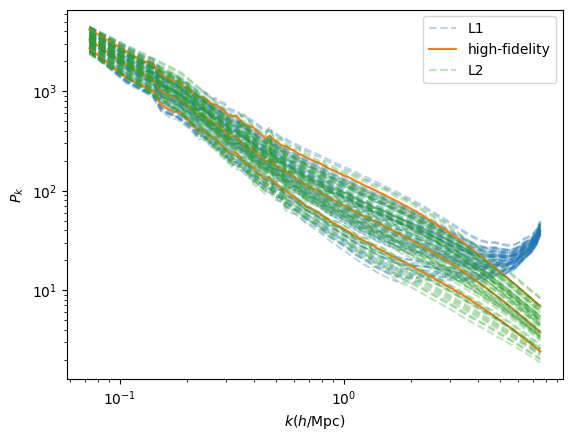

In [15]:
# visualize training spectra
# L1 : some interparticle spacing artefacts at the small k
for i, y_train in enumerate(data_1.Y_train[0]):
    if i == 0:
        plt.loglog(
            10**data_1.kf, 10**y_train, label="L1", color="C0", ls="--", alpha=0.3
        )
    else:
        plt.loglog(10**data_1.kf, 10**y_train, color="C0", ls="--", alpha=0.3)
for i, y_train in enumerate(data_1.Y_train[1]):
    if i == 0:
        plt.loglog(10**data_1.kf, 10**y_train, label="high-fidelity", color="C1")
    else:
        plt.loglog(10**data_1.kf, 10**y_train, color="C1")

# L2 : smaller box
for i, y_train in enumerate(data_2.Y_train[0]):
    if i == 0:
        plt.loglog(
            10**data_2.kf, 10**y_train, label="L2", color="C2", ls="--", alpha=0.3
        )
    else:
        plt.loglog(10**data_2.kf, 10**y_train, color="C2", ls="--", alpha=0.3)

plt.legend()
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$P_{k}$")

The above plot shows 3 HF spectra and 60 L1 an 60 L2 spectra. We only consider the k range covered by L1, L2, and HF.


Text(0, 0.5, '$P_{k}$')

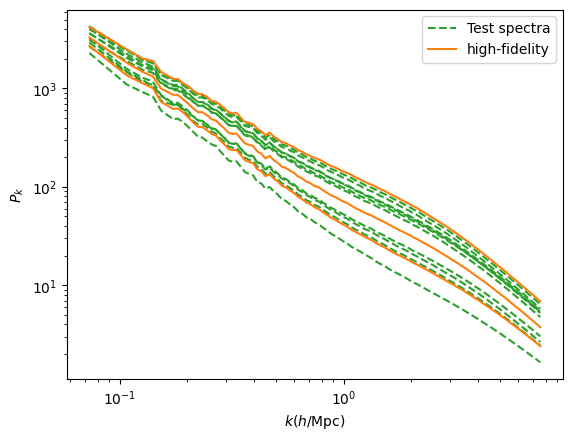

In [16]:
# visualize the testing data
# visualize training spectra
for i, y_train in enumerate(data_1.Y_test[0]):
    if i == 0:
        plt.loglog(
            10**data_1.kf, 10**y_train, label="Test spectra", color="C2", ls="--"
        )
    else:
        plt.loglog(10**data_1.kf, 10**y_train, color="C2", ls="--")
for i, y_train in enumerate(data_1.Y_train[1]):
    if i == 0:
        plt.loglog(10**data_1.kf, 10**y_train, label="high-fidelity", color="C1")
    else:
        plt.loglog(10**data_1.kf, 10**y_train, color="C1")
plt.legend()
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$P_{k}$")

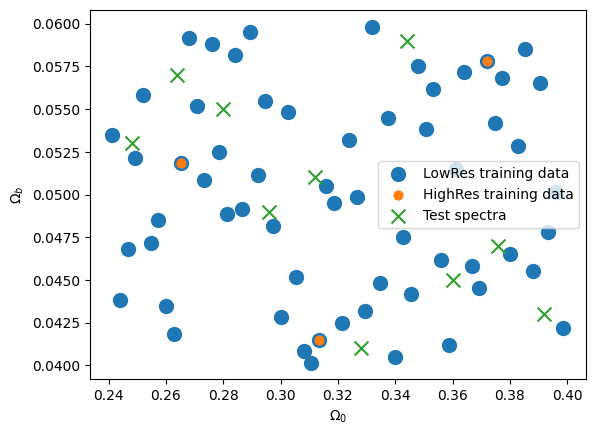

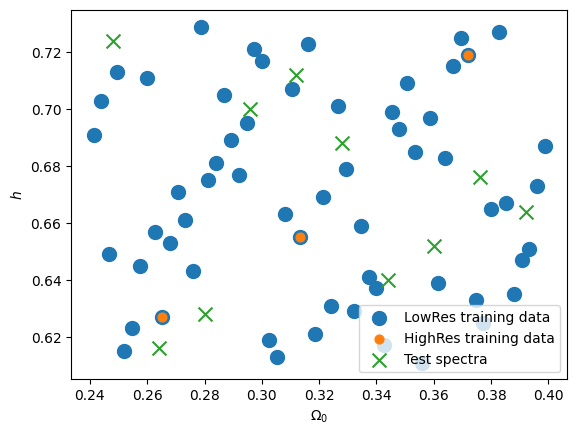

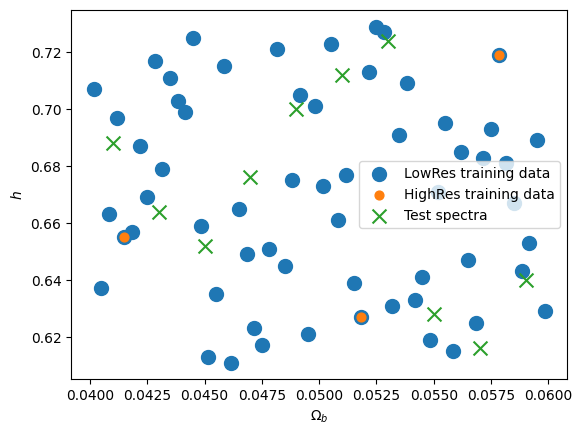

In [17]:
# nested training inputs
plot_parameters(
    [data_1.X_train[0][:, :3], data_1.X_train[1][:, :3]],
    [data_1.X_test[0][:, :3]],
    parameter_names=[r"$\Omega_0$", r"$\Omega_b$", r"$h$"],
)


## Building emulators


In [18]:
# only support 2 fidelities now
n_fidelities = 2
n_optimization_restarts = (
    15  # repeat optimizations and choose the best one; more is better.
)
# recommend: >= 30

# whether to have Automatic Relevance Determination at the bias kernel
ARD_last_fidelity = False

# whether you want parallel in the optimization_restarts
parallel = False


In [19]:
# Multi-fidelity
# linear multi-fidelity GP
ar1 = SingleBinLinearGP(
    data_1.X_train_norm,
    data_1.Y_train_norm,
    kernel_list=None,
    n_fidelities=n_fidelities,
)
# non-linear multi-fidelity GP
nargp = SingleBinNonLinearGP(
    data_1.X_train_norm,
    data_1.Y_train_norm,
    n_fidelities=n_fidelities,
    n_samples=500,
    optimization_restarts=n_optimization_restarts,
)


# Single-fidelity
# high-fidelity only emulator
hf_only = SingleBinGP(data_1.X_train_norm[-1], data_1.Y_train[-1])
lf_only = SingleBinGP(data_1.X_train_norm[0], data_1.Y_train[0])


In [20]:
%%capture
# Graphical GP
# Data (M1, M2, H)
dgmgp = SingleBindGMGP(
    X_train=[data_1.X_train_norm[0], data_2.X_train_norm[0], data_1.X_train_norm[1]],
    Y_train=[data_1.Y_train_norm[0], data_2.Y_train_norm[0], data_1.Y_train_norm[1]],
    n_fidelities=n_fidelities,
    n_samples=500,
    optimization_restarts=n_optimization_restarts,
    ARD_last_fidelity=ARD_last_fidelity,
    parallel=parallel,
)

# optimize each model
ar1.optimize(n_optimization_restarts=n_optimization_restarts)
nargp.optimize()
hf_only.optimize_restarts(n_optimization_restarts=n_optimization_restarts)
lf_only.optimize_restarts(n_optimization_restarts=n_optimization_restarts)

## Predictions


In [21]:
# testing set
modes_dgmgp, vars_dgmgp, pred_exacts_dgmgp = validate_dgmgp(data_1, model=dgmgp)
modes_ar1, vars_ar1, pred_exacts_ar1 = validate_mf(data_1, model=ar1)
modes_nargp, vars_nargp, pred_exacts_nargp = validate_mf(data_1, model=nargp)
modes_hfonly, vars_hfonly, pred_exacts_hfonly = validate_sf(data_1, model=hf_only)
modes_lfonly, vars_lfonly, pred_exacts_lfonly = validate_sf(data_1, model=lf_only)


MF-Box versus MFEmulator using only one box size.


In [22]:
def _test_validate_mf(data: PowerSpecs, model: SingleBinNonLinearGP, fidelity: int = 1):
    """
    Validate the trained MFEmulators
    """
    x_test, y_test = data.X_test_norm[0], data.Y_test[0]

    mean, var = model.predict(x_test)

    # dx = x dlog(x) = log(10) x dlog10(x)
    # dlog10(x) = d(log(x) / log(10))
    vars = (10**mean * np.log(10) * np.sqrt(var)) ** 2

    # predicted/exact
    pred_exacts = 10**mean / 10**y_test

    return mean, vars, pred_exacts


def _test_validate_mf_single(
    data: PowerSpecs, model: SingleBinNonLinearGP, fidelity: int = 1
):
    """
    Validate the trained MFEmulators
    ----

    Parameters:
    ----
    fidelity: the output fidelity. Default fidelity=1, the second fidelity.

    Returns:
    ----
    all_means: predictied means from the GP (in log10 scale).
    all_vars: predictied variance from the GP (in log10 scale).
    all_pred_exacts: Predicted/Exact (in linear scale).
    """
    all_means = []
    all_vars = []
    all_pred_exacts = []
    for n_validations, (x_test, y_test) in enumerate(
        zip(data.X_test_norm[0], data.Y_test[0])
    ):
        x_test_index = np.concatenate(
            (x_test[None, :], np.ones((1, 1)) * fidelity), axis=1
        )
        mean, var = model.predict(x_test_index)

        all_means.append(mean[0])
        # dx = x dlog(x) = log(10) x dlog10(x)
        # dlog10(x) = d(log(x) / log(10))
        all_vars.append((10 ** mean[0] * np.log(10) * np.sqrt(var[0])) ** 2)

        # predicted/exact
        all_pred_exacts.append(10 ** mean[0] / 10**y_test)

    return all_means, all_vars, all_pred_exacts


_means_dgmgp, _vars_dgmgp, _pred_exacts_dgmgp = _test_validate_mf(data_1, model=dgmgp)
_means_nargp, _vars_nargp, _pred_exacts_nargp = _test_validate_mf_single(
    data_1, model=nargp
)


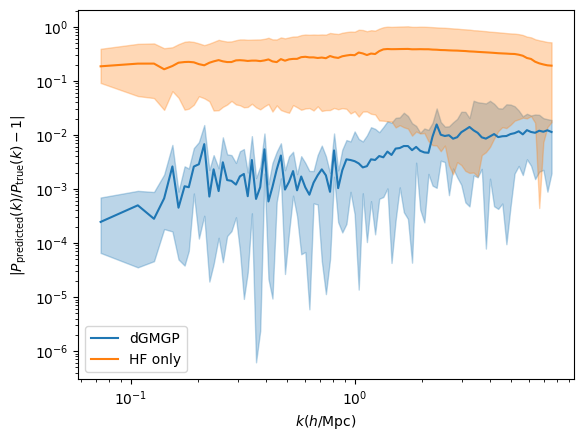

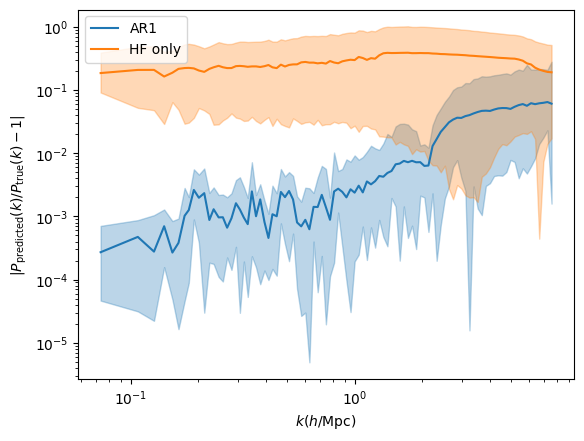

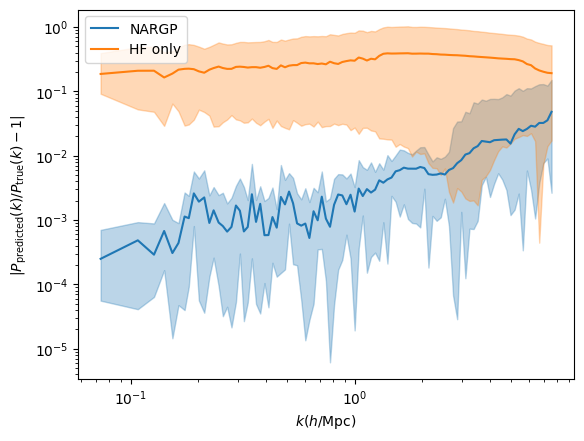

In [23]:
do_emulator_error_plots(
    data_1,
    modes_dgmgp,
    modes_hfonly,
    pred_exacts_dgmgp,
    pred_exacts_hfonly,
    label_mf="dGMGP",
    label_sf="HF only",
    figure_name="dGMGP",
)

do_emulator_error_plots(
    data_1,
    modes_ar1,
    modes_hfonly,
    pred_exacts_ar1,
    pred_exacts_hfonly,
    label_mf="AR1",
    label_sf="HF only",
    figure_name="ar1",
)
do_emulator_error_plots(
    data_1,
    modes_nargp,
    modes_hfonly,
    pred_exacts_nargp,
    pred_exacts_hfonly,
    label_mf="NARGP",
    label_sf="HF only",
    figure_name="nargp",
)

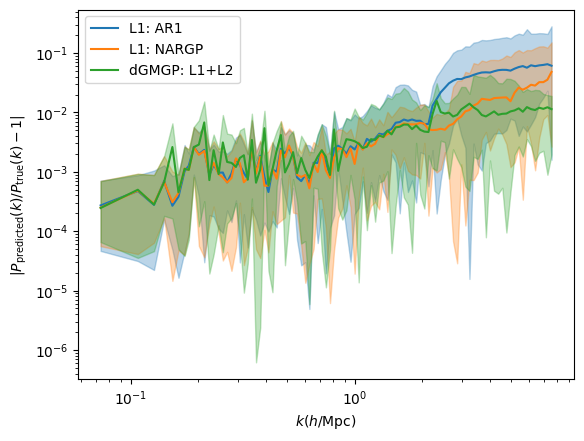

In [24]:
emulator_comparison_list(
    [data_1.kf, data_1.kf, data_1.kf],
    [pred_exacts_ar1, pred_exacts_nargp, pred_exacts_dgmgp],
    ["L1: AR1", "L1: NARGP", "dGMGP: L1+L2"],
)
plt.legend()

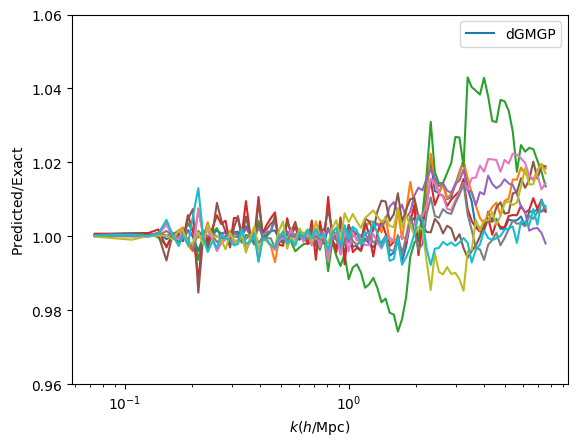

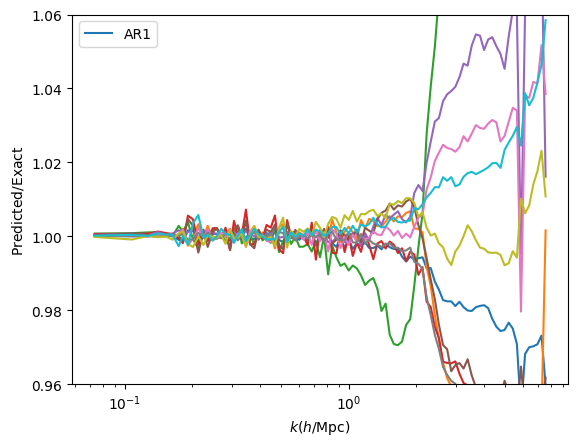

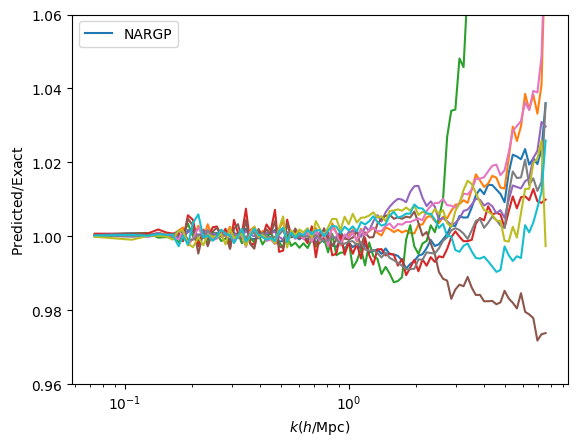

In [25]:
# pred/exact plot
do_pred_exact(
    data_1, modes_dgmgp, pred_exacts_dgmgp, label_mf="dGMGP", figure_name="dgmgp"
)
do_pred_exact(data_1, modes_ar1, pred_exacts_ar1, label_mf="AR1", figure_name="ar1")
do_pred_exact(
    data_1, modes_nargp, pred_exacts_nargp, label_mf="NARGP", figure_name="nargp"
)